# Calibrating HBV hydrological model using SCE run locally outside container forced with ERA5 forcing data
In this notebook we will demonstrate how to calibrate the HBV model with SCE and works as an example for calibration methods that use a function that needs to be passed to an optimization algorithm. 

Instead of an ensemble of models, we will need to construct a function that does the entire model run.

We will use an extention to eWaterCycle: eWaterCycle-DA with DA for Data Assimilation. This package, developed by former MSc student David Haasnoot, adds functionality to deal with ensembles of models in eWaterCycle.

This assumes you have already seen [the standard notebook explaining how to run HBV on eWaterCycle.](example_model_run_HBV_camels_catchment_camels_forcing.ipynb)

Only cells which differ from that notebook are shown here, other cells are collapsed for easier viewing (but can be opened and are, of course, run!).

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json

# Niceties
from rich import print
from tqdm import tqdm

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
# We need the sceua package. If that is not available on your machine,
# uncomment the line below to install it

!pip install sceua

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
esmvalcore 2.11.1 requires numpy!=1.24.3,<2.0.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.


In [4]:
# Sceua package
import sceua

In [5]:
# # We make use of the hydrobm package to calculate metrics
# !pip install hydrobm

In [6]:
from hydrobm.metrics import calculate_metric

In [7]:
# Load settings
# Read from the JSON file
with open("settings.json", "r") as json_file:
    settings = json.load(json_file)

In [8]:
print(settings)

{
    'caravan_id': 'hysets_01371500',
    'calibration_start_date': '1997-08-01T00:00:00Z',
    'calibration_end_date': '2007-07-31T00:00:00Z',
    'validation_start_date': '2007-08-01T00:00:00Z',
    'validation_end_date': '2010-07-31T00:00:00Z',
    'future_start_date': '2027-08-01T00:00:00Z',
    'future_end_date': '2047-08-31T00:00:00Z',
    'CMIP_info': {
        'dataset': ['MPI-ESM1-2-HR'],
        'ensembles': ['r1i1p1f1'],
        'experiments': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
        'project': 'CMIP6',
        'frequency': 'day',
        'grid': 'gn',
        'variables': ['pr', 'tas', 'rsds']
    },
    'base_path': '/home/rhut/ewatercycleClimateImpact/HBV',
    'path_caravan': '/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/caravan',
    'path_ERA5': '/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/ERA5',
    'path_CMIP6': '/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/CMIP6',
    'path_shape': '/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/caravan/hysets_01371500.shp'
}

# Pre-generated observations of discharge from caravan
Here we re-load the disharge data we generated in [this](step_0a_select_caravan_region_time_and_scenarios.ipynb) notebook.

In [9]:
# Load the caravan forcing object
caravan_data_object = ewatercycle.forcing.sources['CaravanForcing'].load(directory=settings['path_caravan'])
print(caravan_data_object)

CaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2010-07-31T00:00:00Z',
    directory=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/caravan'),
    shape=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/caravan/hysets_01371500.shp'),
    filenames={
        'tas': 'hysets_01371500_1997-08-01_2010-07-31_tas.nc',
        'Q': 'hysets_01371500_1997-08-01_2010-07-31_Q.nc',
        'pr': 'hysets_01371500_1997-08-01_2010-07-31_pr.nc',
        'tasmin': 'hysets_01371500_1997-08-01_2010-07-31_tasmin.nc',
        'evspsblpot': 'hysets_01371500_1997-08-01_2010-07-31_evspsblpot.nc',
        'tasmax': 'hysets_01371500_1997-08-01_2010-07-31_tasmax.nc'
    }
)

## Pre-generated ERA5 forcing data for HBV model
Here we load the ERA5 data we generated in [this](step_1a_generate_historical_forcing) notebook

In [10]:
load_location = Path(settings['path_ERA5']) / "work" / "diagnostic" / "script" 
ERA5_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [11]:
print(ERA5_forcing_object)

LumpedMakkinkForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2010-07-31T00:00:00Z',
    directory=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/ERA5/work/diagnostic/script')
,
    shape=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/ERA5/work/diagnostic/script/hyset
s_01371500.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_1997-2010.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_1997-2010.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_1997-2010.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

## Calibration basics and objective function
In model calibration, we are looking for a set of parameters such that when the model is run with that set of parameters, we get the best model output. What "best" means differs per application or research question. In general, we like some model outputs to be as close as possible to observations. For this purpose we create an objective function that takes the model output of interest and observations as inputs and calculates some score that shows goodness of fit. Here we use a RMS difference function:

In [12]:
def calibrationObjective(model_output, observation, start_calibration, end_calibration, metric = 'rmse'):
    '''A function that takes in two dataFrames, interpolates the model output to the
    observations and calculates the average absolute difference between the two. '''

    # Combine the two in one dataFrame and interpolate, to make sure times match
    hydro_data = pd.concat([model_output.reindex(observation.index, method = 'ffill'), observation], axis=1,
                           keys=['model','observation'])

    # Only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    obs = hydro_data['observation'].to_numpy()
    sim = hydro_data['model'].to_numpy()

    metric  = calculate_metric(obs,sim,'kge')

    return metric

    # match metric:
    #     case 'rmse':
    #         # Calculate mean absolute difference
    #         squareDiff = (sim - obs)**2
    #         rmse = np.sqrt(np.mean(squareDiff))
    #         return rmse
    #     case 'nse':
    #         # Calculate Nash Shutcliff Efficiency
    #         nse = 1 - np.sum((obs - sim) ** 2) / np.sum((obs - np.mean(obs)) ** 2)
    #         return nse
    #     case 'kge':
    #         # Calculate Kling Gupta Efficiency
    #         if (np.std(obs) == 0) or (np.std(sim) == 0):
    #             r = 0
    #         else:
    #             r = np.corrcoef(obs, sim)[0, 1]
    #         alpha = np.std(sim) / np.std(obs)
    #         beta = np.mean(sim) / np.mean(obs)
    #         kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    #         return kge


## Create a function that runs the entire model and evaluates it


In [13]:
# Create an array with parameter values.

# First set minimum and maximum values on the parameters
p_min_initial = np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,   0.01])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,   10.0])

p_initial = (p_min_initial + p_min_initial)/2

In [14]:
# Print parameter names and values for first ensemble member
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
print(list(zip(param_names, np.round(p_initial, decimals=3))))

[
    ('Imax', 0.0),
    ('Ce', 0.2),
    ('Sumax', 40.0),
    ('Beta', 0.5),
    ('Pmax', 0.001),
    ('Tlag', 1.0),
    ('Kf', 0.01),
    ('Ks', 0.0),
    ('FM', 0.01)
]

In [15]:
# Set initial state values
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

In [16]:
# Create a dataframe for the observations
ds_observation = xr.open_mfdataset([caravan_data_object['Q']]).to_pandas()
ds_observation = ds_observation['Q']

In [17]:
def runModel(params, forcing_object, observations, initial_state, start_calibration, end_calibration):
    # Create model object, notice the forcing object.
    model = ewatercycle.models.HBVLocal(forcing=forcing_object)

    # Create config file in model.setup()
    config_file, _ = model.setup(parameters=params, initial_storage=initial_state,
                                start_time = start_calibration, end_time = end_calibration)
    # Initialize model
    model.initialize(config_file)
    # Run model, capture calculated discharge and timestamps
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        Q_m.append(model.get_value("Q")[0])
        time.append(pd.Timestamp(model.time_as_datetime))
    # Finalize model (shuts down container, frees memory)
    model.finalize()

    # Make a pandas series
    model_output = pd.Series(data=Q_m, name="modelled discharge", index=time)

    return model_output

In [18]:
def runModelReturnObjective(params, forcing_object, observations, initial_state, start_calibration, end_calibration):

    model_output = runModel(params, forcing_object, observations, initial_state, start_calibration, end_calibration)

    kge = calibrationObjective(model_output, observations, start_calibration, end_calibration, metric = 'kge')

    # kge is best if high, so we do one minus kge to make sure that sce optimizes correctly
    # since sce always minimizes

    score = 1 - kge

    return score

## Find best parameter set
By calculating the objective function for each model output, we can search the combination of parameters with the lowest objective function.

In [19]:
# Define parameter bounds as a sequence of (min, max) pairs
bounds = [(p_min_initial[n], p_max_initial[n]) for n in range(len(p_min_initial))]

print(bounds)



[
    (0.0, 8.0),
    (0.2, 1.0),
    (40.0, 800.0),
    (0.5, 4.0),
    (0.001, 0.3),
    (1.0, 10.0),
    (0.01, 0.1),
    (0.0001, 0.01),
    (0.01, 10.0)
]

In [20]:
# Run optimization
result = sceua.minimize(runModelReturnObjective, bounds, args=(ERA5_forcing_object, ds_observation, s_0, settings['calibration_start_date'],
                                                              settings['calibration_end_date']), seed=42, max_workers=1)


In [21]:
# Access the optimization results
best_params = result.x
best_function_value = result.fun
num_iterations = result.nit
num_function_evaluations = result.nfev

In [22]:
print(best_function_value)

0.42566593523416385

In [23]:
model_output = runModel(best_params, ERA5_forcing_object, ds_observation, s_0, 
                                              settings['calibration_start_date'], settings['calibration_end_date'])

In [24]:
# Create a dataframe for the observations
ds_observation = xr.open_mfdataset([caravan_data_object['Q']]).to_pandas()

<Axes: xlabel='time'>

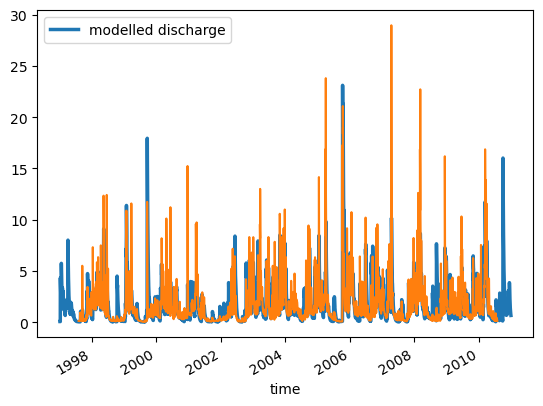

In [25]:
# Make a plot of the model output of the minimum value
ax = model_output.plot(lw=2.5)
plt.legend()
ds_observation["Q"].plot()

In [26]:
df_best = model_output

In [27]:
df_best.index = df_best.index.tz_localize("UTC")
df_select = df_best.tz_convert("UTC")[settings['validation_start_date']:settings['validation_end_date']]

(13726.0, 14821.0)

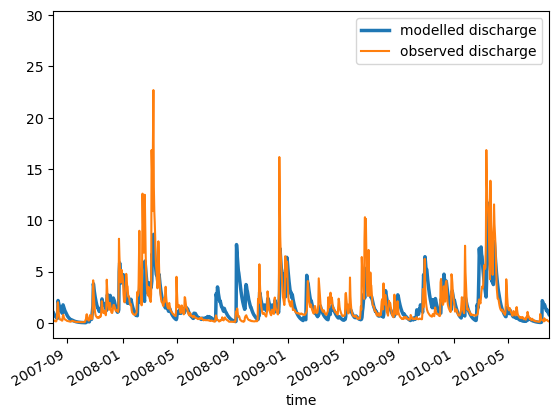

In [28]:
# Make a plot of the model output of the minimum value
ax = df_select.plot(lw=2.5)
ds_observation["Q"].plot(label = 'observed discharge')
plt.legend()
plt.xlim(settings['validation_start_date'],settings['validation_end_date'])

## Save results
We want to save these results to file to be able to load them in other studies.

In [34]:
# Save to csv file
np.savetxt(Path(settings["base_path"]) / "data" / (settings["caravan_id"] + settings['caravan_id'] + "_params_SCE.csv"), best_params, delimiter=",")

In [35]:
# Remove all temporary directories made by the optimization algo.

!rm -rf hbvlocal*

In [36]:
# Re-install correct numpy for ESMVAlTool
!pip install esmvaltool

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sceua 0.1.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
